# Goal Programming: Balancing Multiple Competing Objectives

This notebook demonstrates **goal programming**, a way to handle multiple competing objectives when you cannot achieve all of them perfectly.

Understanding goal programming helps you:
- Set targets for multiple goals
- Find solutions that get as close as possible to all targets
- See why perfect solutions don't exist when goals conflict
- Make informed decisions about which goals to prioritize


## Key Concepts

**Goal Programming** handles multiple competing objectives:
- Sets targets for each goal
- Minimizes deviations from targets
- Finds solutions that get close to all goals, even if not perfect for any single goal

**Why Goal Programming?**
- Real business problems have multiple objectives that conflict
- You cannot achieve all objectives perfectly simultaneously
- Goal programming finds balanced solutions acceptable across all goals

**Critical insight**: Goal programming doesn't find perfect solutions. It finds solutions that balance competing goals, getting as close as possible to all targets.


## Scenario: Project Portfolio Selection

A technology company must decide which projects to fund in the upcoming year. They have multiple goals:

**Goal 1: Minimize Cost**
- Target: Keep total cost under $5 million
- Lower cost is better

**Goal 2: Minimize Time**
- Target: Complete projects within 12 months
- Shorter time is better

**Goal 3: Maximize Quality**
- Target: Achieve at least 90% quality score
- Higher quality is better

These goals conflict: Lower cost might mean lower quality or longer time. Higher quality might mean higher cost or longer time.

**Decision**: Which projects to fund to balance all three goals?


## Step 1: Install Required Packages (Colab)


In [1]:
# Install pulp package (required for optimization)
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value


## Step 3: Define Projects and Goals

Set up the project portfolio problem:


In [3]:
# Available projects
projects = ['Project A', 'Project B', 'Project C', 'Project D', 'Project E']
n_projects = len(projects)

# Project characteristics
project_data = {
    'Project A': {'cost': 1.2, 'time': 10, 'quality': 85},
    'Project B': {'cost': 0.8, 'time': 14, 'quality': 75},
    'Project C': {'cost': 1.5, 'time': 8, 'quality': 95},
    'Project D': {'cost': 0.6, 'time': 16, 'quality': 70},
    'Project E': {'cost': 1.0, 'time': 12, 'quality': 88}
}

# Goal targets
target_cost = 5.0  # Million dollars
target_time = 12   # Months
target_quality = 90  # Quality score

print("PROJECT PORTFOLIO DATA")
print("=" * 70)
df = pd.DataFrame(project_data).T
df.columns = ['Cost ($M)', 'Time (months)', 'Quality Score']
display(df)

print(f"\nGOAL TARGETS:")
print(f"  Cost: Under ${target_cost}M")
print(f"  Time: Under {target_time} months")
print(f"  Quality: At least {target_quality}%")


PROJECT PORTFOLIO DATA


,Cost ($M),Time (months),Quality Score
Project A,1.2,10.0,85.0
Project B,0.8,14.0,75.0
Project C,1.5,8.0,95.0
Project D,0.6,16.0,70.0
Project E,1.0,12.0,88.0



GOAL TARGETS:
  Cost: Under $5.0M
  Time: Under 12 months
  Quality: At least 90%


## Step 4: Build Goal Programming Model

Create a model that minimizes deviations from all three goals:


In [4]:
# Create goal programming model
model = LpProblem("Project_Portfolio_Goals", LpMinimize)

# Decision variables: which projects to fund (binary)
fund = [LpVariable(f"fund_{i}", cat='Binary') for i in range(n_projects)]

# Deviation variables (how far we are from targets)
cost_over = LpVariable("cost_over", lowBound=0)  # Cost over target
time_over = LpVariable("time_over", lowBound=0)   # Time over target
quality_under = LpVariable("quality_under", lowBound=0)  # Quality under target

# Calculate actual values
total_cost = lpSum([project_data[projects[i]]['cost'] * fund[i] for i in range(n_projects)])
total_time = lpSum([project_data[projects[i]]['time'] * fund[i] for i in range(n_projects)])
# Average quality (weighted by cost)
total_quality_cost = lpSum([project_data[projects[i]]['quality'] * project_data[projects[i]]['cost'] * fund[i] 
                            for i in range(n_projects)])
# Note: avg_quality will be calculated after solving (PuLP doesn't allow division by variable expressions)

# Goal constraints (with deviations)
model += total_cost - cost_over <= target_cost, "Cost_Goal"
model += total_time - time_over <= target_time, "Time_Goal"
# For quality, we want average >= target, so if under, quality_under is positive
# We'll use a linear approximation: total_quality >= target * total_cost
model += total_quality_cost >= (target_quality / 100) * total_cost * 100 - quality_under * 100, "Quality_Goal"

# Objective: Minimize weighted sum of deviations
# Weight each deviation by importance
weight_cost = 1.0
weight_time = 0.8
weight_quality = 1.2
model += weight_cost * cost_over + weight_time * time_over + weight_quality * quality_under

# Solve
model.solve()

# Get solution
selected_projects = [projects[i] for i in range(n_projects) if value(fund[i]) > 0.5]
actual_cost = value(total_cost)
actual_time = value(total_time)
actual_quality_cost = value(total_quality_cost)
# Calculate average quality after solving (PuLP doesn't allow division by variables)
actual_quality = (actual_quality_cost / (actual_cost + 0.001)) * 100 if actual_cost > 0 else 0

cost_dev = value(cost_over)
time_dev = value(time_over)
quality_dev = value(quality_under)

print("GOAL PROGRAMMING SOLUTION")
print("=" * 70)
print(f"Selected Projects: {', '.join(selected_projects)}")
print(f"\nActual Results:")
print(f"  Cost: ${actual_cost:.2f}M (Target: ${target_cost}M)")
print(f"  Time: {actual_time:.1f} months (Target: {target_time} months)")
print(f"  Quality: {actual_quality:.1f}% (Target: {target_quality}%)")
print(f"\nDeviations from Targets:")
print(f"  Cost over target: ${cost_dev:.2f}M")
print(f"  Time over target: {time_dev:.1f} months")
print(f"  Quality under target: {quality_dev:.1f}%")
print(f"\nTotal Deviation (weighted): {value(model.objective):.2f}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/15700fa4af4a460cac085d7a244f574b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/15700fa4af4a460cac085d7a244f574b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 40 RHS
At line 44 BOUNDS
At line 50 ENDATA
Problem MODEL has 3 rows, 8 columns and 18 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 0 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of 

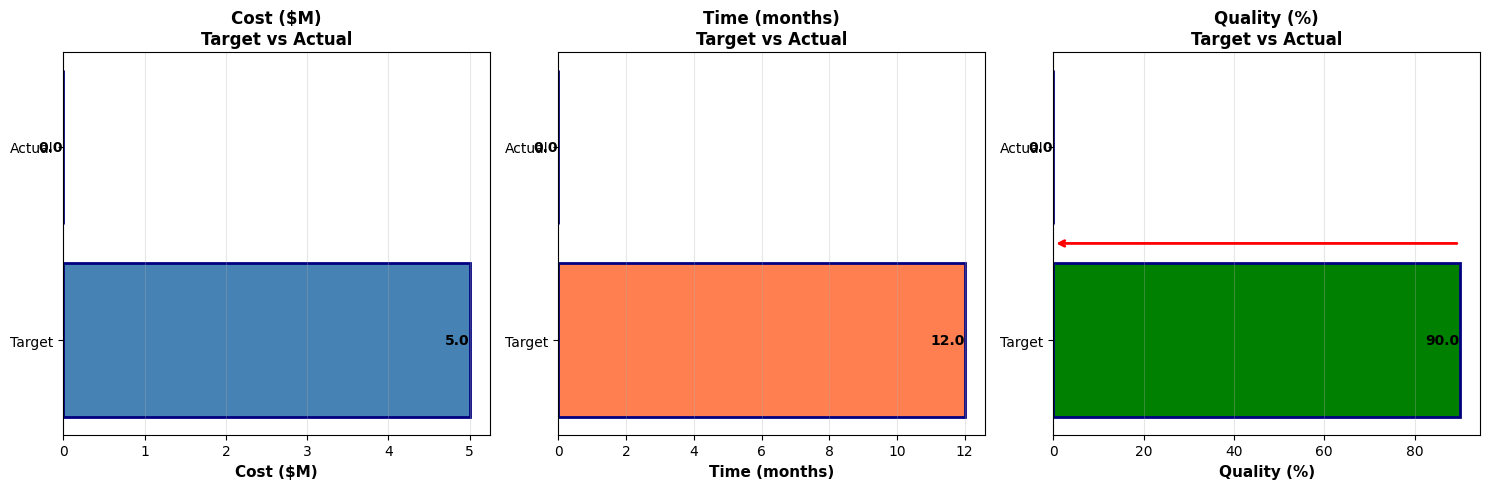


Key Observations:
  - We didn't achieve any target perfectly
  - But we got close to all targets
  - This is a balanced solution acceptable across all goals
  - Goal programming finds solutions that balance competing objectives


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Goal 1: Cost
targets = [target_cost, target_time, target_quality]
actuals = [actual_cost, actual_time, actual_quality]
goals = ['Cost ($M)', 'Time (months)', 'Quality (%)']
colors = ['steelblue', 'coral', 'green']

for i, (goal, target, actual, color) in enumerate(zip(goals, targets, actuals, colors)):
    axes[i].barh(['Target', 'Actual'], [target, actual], color=[color, 'lightgray'], 
                 edgecolor='navy', linewidth=2)
    axes[i].set_xlabel(goal, fontsize=11, fontweight='bold')
    axes[i].set_title(f'{goal}\nTarget vs Actual', fontsize=12, fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    axes[i].text(target, 0, f'{target:.1f}', ha='right', va='center', fontweight='bold')
    axes[i].text(actual, 1, f'{actual:.1f}', ha='right', va='center', fontweight='bold')
    
    # Add deviation arrow
    if i == 0:  # Cost
        if actual > target:
            axes[i].annotate('', xy=(actual, 0.5), xytext=(target, 0.5),
                           arrowprops=dict(arrowstyle='->', color='red', lw=2))
    elif i == 1:  # Time
        if actual > target:
            axes[i].annotate('', xy=(actual, 0.5), xytext=(target, 0.5),
                           arrowprops=dict(arrowstyle='->', color='red', lw=2))
    else:  # Quality
        if actual < target:
            axes[i].annotate('', xy=(actual, 0.5), xytext=(target, 0.5),
                           arrowprops=dict(arrowstyle='->', color='red', lw=2))

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - We didn't achieve any target perfectly")
print("  - But we got close to all targets")
print("  - This is a balanced solution acceptable across all goals")
print("  - Goal programming finds solutions that balance competing objectives")


## Summary: Understanding Goal Programming

**Goal Programming** helps balance multiple competing objectives:
- Sets targets for each goal
- Minimizes deviations from targets
- Finds balanced solutions acceptable across all goals

**Key Takeaways**:
- You cannot achieve all goals perfectly when they conflict
- Goal programming finds solutions that get close to all goals
- Balanced solutions are often better than optimizing for one goal
- Understanding goal programming helps you handle complex multi-objective decisions
